In [3]:
# -*- coding: utf-8 -*-
"""
    load BJ Data from multiple sources as follows:
        meteorologic data
"""
from __future__ import print_function

import os
# import cPickle as pickle
import pickle
from copy import copy
import numpy as np
import h5py
import time
import pandas as pd
from datetime import datetime

# np.random.seed(1337)  # for reproducibility
DATAPATH = './'


class MinMaxNormalization(object):
    '''MinMax Normalization --> [-1, 1]
       x = (x - min) / (max - min).
       x = x * 2 - 1
    '''

    def __init__(self):
        pass

    def fit(self, X):
        self._min = X.min()
        self._max = X.max()
        print("min:", self._min, "max:", self._max)

    def transform(self, X):
        X = 1. * (X - self._min) / (self._max - self._min)
        # X = X * 2. - 1.
        return X

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, X):
        # X = (X + 1.) / 2.
        X = 1. * X * (self._max - self._min) + self._min
        return X


def load_stdata(fname):
    f = pd.read_csv(fname)
    timestamps = [str(t).encode('utf-8') for t in f['index']]
    col_names = f.columns[1:]  # skip 'index'
    
    data = []
    
    for _, row in f.iterrows():
        nb_flow_data = []
        arr_2d = np.zeros((28, 28))  
        for col_name, value in zip(col_names, row[1:]):  # skip index
            index = int(col_name.split('_')[1])-1  # 從 grid_271 → 271
            y = index % 28
            x = index // 28
            arr_2d[y][x] = value
        nb_flow_data.append(arr_2d)
        data.append(nb_flow_data)
    return np.array(data), timestamps


In [4]:
##
def stat(fname):
    def get_nb_timeslot(f):
        s = f['date'][0]
        e = f['date'][-1]
        year, month, day = map(int, [s[:4], s[4:6], s[6:8]])
        ts = time.strptime("%04i-%02i-%02i" % (year, month, day), "%Y-%m-%d")
        year, month, day = map(int, [e[:4], e[4:6], e[6:8]])
        te = time.strptime("%04i-%02i-%02i" % (year, month, day), "%Y-%m-%d")
        nb_timeslot = (time.mktime(te) - time.mktime(ts)) / (0.5 * 3600) + 48
        ts_str, te_str = time.strftime("%Y-%m-%d", ts), time.strftime("%Y-%m-%d", te)
        return nb_timeslot, ts_str, te_str

    with h5py.File(fname) as f:
        nb_timeslot, ts_str, te_str = get_nb_timeslot(f)
        nb_day = int(nb_timeslot / 48)
        mmax = f['data'][:].max()
        mmin = f['data'][:].min()
        stat = '=' * 5 + 'stat' + '=' * 5 + '\n' + \
               'data shape: %s\n' % str(f['data'].shape) + \
               '# of days: %i, from %s to %s\n' % (nb_day, ts_str, te_str) + \
               '# of timeslots: %i\n' % int(nb_timeslot) + \
               '# of timeslots (available): %i\n' % f['date'].shape[0] + \
               'missing ratio of timeslots: %.1f%%\n' % ((1. - float(f['date'].shape[0] / nb_timeslot)) * 100) + \
               'max: %.3f, min: %.3f\n' % (mmax, mmin) + \
               '=' * 5 + 'stat' + '=' * 5
        print(stat)

##
def timestamp2vec(timestamps):
    # tm_wday range [0, 6], Monday is 0
    # vec = [time.strptime(str(t[:8], encoding='utf-8'), '%Y%m%d').tm_wday for t in timestamps]  # python3
    vec = [time.strptime(str(t[:8], encoding='utf-8'), '%Y%m%d').tm_wday for t in timestamps]  # python2
    ret = []
    for i in vec:
        v = [0 for _ in range(7)]
        v[i] = 1
        if i >= 5:
            v.append(0)  # weekend
        else:
            v.append(1)  # weekday
        ret.append(v)
    return np.asarray(ret) # 給多少天有多少 [0, 0, 1, 0, 0, 0, 0, 1] 星期三平日


def string2timestamp(strings, T=6):
    timestamps = []

    time_per_slot = 24.0 / T

    for t in strings:
        # t = str(t)
        year = int(t[:4])
        month = int(t[4:6])
        day = int(t[6:8])
        slot = int(t[8:]) - 1
        total_minutes = slot * time_per_slot * 60
        hour = int(total_minutes // 60)
        minute = int(total_minutes % 60)
        timestamps.append(pd.Timestamp(datetime(year, month, day, hour=hour, minute=minute)))
    return timestamps

def remove_incomplete_days(data, timestamps, T=48):
    # remove a certain day which has not 48 timestamps
    days = []  # available days: some day only contain some seqs
    days_incomplete = []
    i = 0
    while i < len(timestamps):
        if int(timestamps[i][8:]) != 1:
            i += 1
        elif i + T - 1 < len(timestamps) and int(timestamps[i + T - 1][8:]) == T:
            days.append(timestamps[i][:8])
            i += T
        else:
            days_incomplete.append(timestamps[i][:8])
            i += 1
    print("incomplete days: ", days_incomplete)
    days = set(days)
    idx = []
    for i, t in enumerate(timestamps):
        if t[:8] in days:
            idx.append(i)

    data = data[idx]
    timestamps = [timestamps[i] for i in idx]
    return data, timestamps

In [5]:

def load_meteorol(timeslots, fname):
    '''
    讀取時間戳對應的 meta 特徵：
    - rush hour
    - weekend
    - holiday
    - make-up workday
    - day of week
    - TX01
    '''
    M = dict()
    for year in [107, 108, 112, 113]:
        fname = '../dataset_4yr\TPE_{}_attribute_weather.csv'.format(year)
        f = pd.read_csv(fname, dtype={'index': str})
        # 把 timestamp index 做成 dict
        
        for i, row in f.iterrows():
            slot = row['index']
            if slot not in M:  # 如果還沒出現過，才加進去
                M[slot] = i
    print(M)
    # 準備要取出的特徵欄
    rush_hour = []
    weekend = []
    holiday = []
    make_up = []
    day_of_week = []
    weather = []
    timeslots = [t.decode('utf-8') if isinstance(t, bytes) else t for t in timeslots]

    print(timeslots)
    for slot in timeslots:
        if slot not in M:
            # 若沒對應到就填 0
            rush_hour.append(0)
            weekend.append(0)
            holiday.append(0)
            make_up.append(0)
            day_of_week.append(0)
            weather.append(0)
            
        else:
            i = M[slot]
            rush_hour.append(f.loc[i, 'Rush_Hour'])
            weekend.append(f.loc[i, 'Weekend'])
            holiday.append(f.loc[i, 'Holiday'])
            make_up.append(f.loc[i, 'make_up_workday'])
            day_of_week.append(f.loc[i, 'Day_of_Week'])
            weather.append(f.loc[i, 'TX01'])
            # print("match")

    # 將 list 轉成 numpy array 並合併
    rush_hour = np.asarray(rush_hour)
    weekend = np.asarray(weekend)
    holiday = np.asarray(holiday)
    make_up = np.asarray(make_up)
    day_of_week = np.asarray(day_of_week)
    weather = np.asarray(weather)

    # 合併成一個 array
    merge_data = np.stack([rush_hour, weekend, holiday, make_up, day_of_week, weather], axis=1)

    print("External data shape:", merge_data.shape)
    return merge_data


# load_population():

In [ ]:
def load_population(timeslots):
    # load data
    data_all = []
    timestamps_all = []
    for year in [107, 108, 112, 113]:
        fname = 'dataset_4yr/TPE_{}_pop.csv'.format(year)
        print("file name: ", fname)
        data, timestamps = load_stdata(fname)  # assume shape: (N, 1, 28, 28)
        data = data.reshape(data.shape[0], -1, 1)  # => (N, 784, 1)
        data_all.append(data)
        timestamps_all.append(timestamps)
    timeslots = [t.decode('utf-8') if isinstance(t, bytes) else t for t in timeslots]

    for slot in timeslots:
        if slot not in timestamps_all[0]:
            # 若沒對應到就填 0
            data_all.append(np.zeros((1, 784, 1)))
            timestamps_all.append(slot)
        else:
            print("match")
            idx = timestamps_all[0].index(slot)
            for i in range(len(data_all)):
                data_all[i] = data_all[i][idx:idx+1]
    # 合併所有年份的資料
    data_all = np.concatenate(data_all, axis=0)
    timestamps_all = np.concatenate(timestamps_all, axis=0)

    print("Loaded population shape:", data_all.shape)  
    return data_all



In [46]:
load_population()

file name:  ../dataset_4yr/TPE_107_pop.csv
Loaded data shape: (2190, 784, 1)
file name:  ../dataset_4yr/TPE_108_pop.csv
Loaded data shape: (2190, 784, 1)
file name:  ../dataset_4yr/TPE_112_pop.csv
Loaded data shape: (2190, 784, 1)
file name:  ../dataset_4yr/TPE_113_pop.csv
Loaded data shape: (2196, 784, 1)
Loaded population shape: (8766, 784, 1)


array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], shape=(8766, 784, 1))

In [29]:


class STMatrix(object):
    """docstring for STMatrix"""

    def __init__(self, data, timestamps, T=6, CheckComplete=True):
        super(STMatrix, self).__init__()
        assert len(data) == len(timestamps)
        self.data = data
        self.timestamps = timestamps
        self.T = T
        self.pd_timestamps = string2timestamp(timestamps, T=self.T)
        if CheckComplete:
            self.check_complete()
        # index
        self.make_index()

    def make_index(self):
        self.get_index = dict()
        for i, ts in enumerate(self.pd_timestamps):
            self.get_index[ts] = i

    def check_complete(self):
        missing_timestamps = []
        offset = pd.DateOffset(minutes=24 * 60 // self.T)
        pd_timestamps = self.pd_timestamps
        i = 1
        while i < len(pd_timestamps):
            if pd_timestamps[i - 1] + offset != pd_timestamps[i]:
                missing_timestamps.append("(%s -- %s)" % (pd_timestamps[i - 1], pd_timestamps[i]))
            i += 1
        for v in missing_timestamps:
            print(v)
        assert len(missing_timestamps) == 0

    def get_matrix(self, timestamp):
        return self.data[self.get_index[timestamp]]

    def save(self, fname):
        pass

    def check_it(self, depends):
        for d in depends:
            if d not in self.get_index.keys():
                return False
        return True

    def create_dataset(self, len_closeness=3, len_trend=3, TrendInterval=7, len_period=3, PeriodInterval=1):
        """current version
        """
        # offset_week = pd.DateOffset(days=7)
        offset_frame = pd.DateOffset(minutes=24 * 60 // self.T)
        XC = []
        XP = []
        XT = []
        Y = []
        timestamps_Y = []
        depends = [range(1, len_closeness + 1),
                   [PeriodInterval * self.T * j for j in range(1, len_period + 1)],
                   [TrendInterval * self.T * j for j in range(1, len_trend + 1)]]

        i = max(self.T * TrendInterval * len_trend, self.T * PeriodInterval * len_period, len_closeness)
        while i < len(self.pd_timestamps):
            Flag = True
            for depend in depends:
                if Flag is False:
                    break
                Flag = self.check_it([self.pd_timestamps[i] - j * offset_frame for j in depend])

            if Flag is False:
                i += 1
                continue
            x_c = [self.get_matrix(self.pd_timestamps[i] - j * offset_frame) for j in depends[0]]
            x_p = [self.get_matrix(self.pd_timestamps[i] - j * offset_frame) for j in depends[1]]
            x_t = [self.get_matrix(self.pd_timestamps[i] - j * offset_frame) for j in depends[2]]
            y = self.get_matrix(self.pd_timestamps[i])

            # print("x_c shape:", np.asarray(x_c).shape)
            
            if len_closeness > 0:
                XC.append(np.asarray(x_c)[::-1, :, :, :])
            if len_period > 0:
                XP.append(np.asarray(x_p)[::-1, :, :, :])
            if len_trend > 0:
                XT.append(np.asarray(x_t)[::-1, :, :, :])
            Y.append(y)
            timestamps_Y.append(self.timestamps[i])
            i += 1
        XC = np.asarray(XC)
        XP = np.asarray(XP)
        XT = np.asarray(XT)
        Y = np.asarray(Y)
        print("XC shape: ", XC.shape, "XP shape: ", XP.shape, "XT shape: ", XT.shape, "Y shape:", Y.shape)
        return XC, XP, XT, Y, timestamps_Y


# load_data(

In [30]:


def load_data(T=6, nb_flow=1, len_closeness=6, len_period=1, len_trend=1,
              len_test=1, preprocess_name='preprocessing.pkl',
              meta_data=True, meteorol_data=True, holiday_data=True):
    """
    """
    assert (len_closeness + len_period + len_trend > 0)
    # load data
    data_all = []
    timestamps_all = list()
    for year in [107, 108, 112, 113]:
        fname = '../dataset_4yr\TPE_{}_grid.csv'.format(year)
        print("file name: ", fname)
        # stat(fname)
        data, timestamps = load_stdata(fname)
        print("Loaded data shape:", data.shape)
        # remove a certain day which does not have 48 timestamps
        data, timestamps = remove_incomplete_days(data, timestamps, T)
        data = data[:, :nb_flow]
        data[data < 0] = 0.
        data_all.append(data)
        timestamps_all.append(timestamps)
        print("\n")

    # minmax_scale
    data_train = np.vstack(copy(data_all))[:-len_test]
    print('train_data shape: ', data_train.shape)
    mmn = MinMaxNormalization()
    mmn.fit(data_train)
    data_all_mmn = [mmn.transform(d) for d in data_all]

    fpkl = open(preprocess_name, 'wb')
    for obj in [mmn]:
        pickle.dump(obj, fpkl)
    fpkl.close()

    XC, XP, XT = [], [], []
    Y = []
    timestamps_Y = []
    for data, timestamps in zip(data_all_mmn, timestamps_all):
        # instance-based dataset --> sequences with format as (X, Y) where X is
        # a sequence of images and Y is an image.
        st = STMatrix(data, timestamps, T, CheckComplete=False)
        _XC, _XP, _XT, _Y, _timestamps_Y = st.create_dataset(
            len_closeness=len_closeness, len_period=len_period, len_trend=len_trend)
        XC.append(_XC)
        XP.append(_XP)
        XT.append(_XT)
        Y.append(_Y)
        timestamps_Y += _timestamps_Y

    meta_feature = []
    if meta_data:
        # load time feature
        time_feature = timestamp2vec(timestamps_Y)
        meta_feature.append(time_feature)
    print("meta_feature" , meta_feature)
    if meteorol_data:
        # load meteorol data
        for year in [107, 108, 112, 113]:
            fname = '../dataset_4yr\TPE_{}_attribute_weather.csv'.format(year)
            meteorol_feature=(load_meteorol(timestamps_Y,fname))
            meta_feature.append(meteorol_feature)
    print("meta_feature" , meta_feature)
    meta_feature = np.hstack(meta_feature) if len(
        meta_feature) > 0 else np.asarray(meta_feature)
    metadata_dim = meta_feature.shape[1] if len(
        meta_feature.shape) > 1 else None
    if metadata_dim < 1:
        metadata_dim = None
    # if meta_data and holiday_data and meteorol_data:
    #     print('time feature:', time_feature.shape, 'holiday feature:', holiday_feature.shape,
    #           'meteorol feature: ', meteorol_feature.shape, 'mete feature: ', meta_feature.shape)

    XC = np.vstack(XC)
    XP = np.vstack(XP)
    XT = np.vstack(XT)
    Y = np.vstack(Y)
    print("XC shape: ", XC.shape, "XP shape: ", XP.shape,
          "XT shape: ", XT.shape, "Y shape:", Y.shape)

    test = int(XC.shape[0] * 0.2)
    XC_train, XP_train, XT_train, Y_train = XC[:-len_test], XP[:-len_test], XT[:-len_test], Y[:-len_test]
    XC_test, XP_test, XT_test, Y_test = XC[-len_test:], XP[-len_test:], XT[-len_test:], Y[-len_test:]
    timestamp_train, timestamp_test = timestamps_Y[:-len_test], timestamps_Y[-len_test:]
    meta_feature_train, meta_feature_test = meta_feature[:-len_test], meta_feature[-len_test:]

    # Last four weeks as test data, remaining as training data. 90% training data for training, 10% for validation
    split_num = int(len(XC_train) * 0.125)
    XC_strain, XP_strain, XT_strain, Y_strain, meta_feature_strain = XC_train[:-split_num], XP_train[:-split_num], \
                                                                     XT_train[:-split_num], Y_train[:-split_num],\
                                                                     meta_feature_train[:-split_num]

    XC_valid, XP_valid, XT_valid, Y_valid, meta_feature_valid = XC_train[-split_num:],XP_train[-split_num:], \
                                                                XT_train[-split_num:],Y_train[-split_num:], \
                                                                meta_feature_train[-split_num:]

    print("train shape:", XC_strain.shape, XP_strain.shape, XT_strain.shape, Y_strain.shape, meta_feature_strain.shape)
    print("valid shape:", XC_valid.shape, XP_valid.shape, XT_valid.shape, Y_valid.shape, meta_feature_valid.shape)
    print("test shape:", XC_test.shape, XP_test.shape, XT_test.shape, Y_test.shape, meta_feature_test.shape)

    train_data = {'xc': XC_strain, 'xp': XP_strain, 'xt': XT_strain, 'ys': Y_strain, 'yd': meta_feature_strain}
    valid_data = {'xc': XC_valid, 'xp': XP_valid, 'xt': XT_valid, 'ys': Y_valid, 'yd': meta_feature_valid}
    test_Data = {'xc': XC_test, 'xp': XP_test, 'xt': XT_test, 'ys': Y_test, 'yd': meta_feature_test}

    datapath = "./TPE/flow"
    city_type = 'TPE'
    train_filename = os.path.join(datapath, 'train_' + city_type + '.npz')
    valid_filename = os.path.join(datapath, 'valid_' + city_type + '.npz')
    test_filename = os.path.join(datapath, 'test_' + city_type + '.npz')

    np.savez_compressed(train_filename, xc=train_data['xc'], xp=train_data['xp'], xt=train_data['xt'],
                        ys=train_data['ys'], yd=train_data['yd'])
    np.savez_compressed(valid_filename, xc=valid_data['xc'], xp=valid_data['xp'], xt=valid_data['xt'],
                        ys=valid_data['ys'], yd=valid_data['yd'])
    np.savez_compressed(test_filename, xc=test_Data['xc'], xp=test_Data['xp'], xt=test_Data['xt'],
                        ys=test_Data['ys'], yd=test_Data['yd'])

    print("data generated!")

    X_train = []
    X_test = []
    for l, X_ in zip([len_closeness, len_period, len_trend], [XC_train, XP_train, XT_train]):
        if l > 0:
            X_train.append(X_)
    for l, X_ in zip([len_closeness, len_period, len_trend], [XC_test, XP_test, XT_test]):
        if l > 0:
            X_test.append(X_)
    print('train shape:', XC_train.shape, Y_train.shape,
          'test shape: ', XC_test.shape, Y_test.shape)

    if metadata_dim is not None:
        meta_feature_train, meta_feature_test = meta_feature[:-len_test], meta_feature[-len_test:]
        X_train.append(meta_feature_train)
        X_test.append(meta_feature_test)

    return X_train, Y_train, X_test, Y_test, mmn, metadata_dim, timestamp_train, timestamp_test





<>:11: SyntaxWarning: invalid escape sequence '\T'
<>:60: SyntaxWarning: invalid escape sequence '\T'
<>:11: SyntaxWarning: invalid escape sequence '\T'
<>:60: SyntaxWarning: invalid escape sequence '\T'
C:\Users\user\AppData\Local\Temp\ipykernel_24132\3266610740.py:11: SyntaxWarning: invalid escape sequence '\T'
  fname = '../dataset_4yr\TPE_{}_grid.csv'.format(year)
C:\Users\user\AppData\Local\Temp\ipykernel_24132\3266610740.py:60: SyntaxWarning: invalid escape sequence '\T'
  fname = '../dataset_4yr\TPE_{}_attribute_weather.csv'.format(year)


In [25]:
X_train, Y_train, X_test, Y_test, mmn, metadata_dim, timestamp_train, timestamp_test = load_data()

file name:  ../dataset_4yr\TPE_107_grid.csv
Loaded data shape: (2190, 1, 28, 28)
incomplete days:  []


file name:  ../dataset_4yr\TPE_108_grid.csv
Loaded data shape: (2190, 1, 28, 28)
incomplete days:  []


file name:  ../dataset_4yr\TPE_112_grid.csv
Loaded data shape: (2190, 1, 28, 28)
incomplete days:  []


file name:  ../dataset_4yr\TPE_113_grid.csv
Loaded data shape: (2196, 1, 28, 28)
incomplete days:  []


train_data shape:  (8765, 1, 28, 28)
min: 0.0 max: 32.0
XC shape:  (2148, 6, 1, 28, 28) XP shape:  (2148, 1, 1, 28, 28) XT shape:  (2148, 1, 1, 28, 28) Y shape: (2148, 1, 28, 28)
XC shape:  (2148, 6, 1, 28, 28) XP shape:  (2148, 1, 1, 28, 28) XT shape:  (2148, 1, 1, 28, 28) Y shape: (2148, 1, 28, 28)
XC shape:  (2148, 6, 1, 28, 28) XP shape:  (2148, 1, 1, 28, 28) XT shape:  (2148, 1, 1, 28, 28) Y shape: (2148, 1, 28, 28)
XC shape:  (2154, 6, 1, 28, 28) XP shape:  (2154, 1, 1, 28, 28) XT shape:  (2154, 1, 1, 28, 28) Y shape: (2154, 1, 28, 28)
meta_feature [array([[1, 0, 0, ..., 

In [31]:

if __name__ == '__main__':
    batch_size = 32
    T = 6  # number of time intervals in one day
    len_closeness = 6 # 最近的 6 個時間
    len_period = 1 # 一天前的相同時間點
    len_trend = 1 # 一週前的相同時間點
    nb_residual_unit = 2
    nb_flow = 1
    map_height, map_width = 28, 28
    days_test = 7 * 4  # last 4 weeks as test
    len_test = T * days_test
    X_train, Y_train, X_test, Y_test, mmn, metadata_dim, timestamp_train, timestamp_test = load_data(T=T, nb_flow=nb_flow, len_closeness=len_closeness, len_period=len_period, len_trend=len_trend,
              len_test=len_test, preprocess_name='preprocessing.pkl',
              meta_data=True, meteorol_data=True, holiday_data=True)
    

file name:  ../dataset_4yr\TPE_107_grid.csv
Loaded data shape: (2190, 1, 28, 28)
incomplete days:  []


file name:  ../dataset_4yr\TPE_108_grid.csv
Loaded data shape: (2190, 1, 28, 28)
incomplete days:  []


file name:  ../dataset_4yr\TPE_112_grid.csv
Loaded data shape: (2190, 1, 28, 28)
incomplete days:  []


file name:  ../dataset_4yr\TPE_113_grid.csv
Loaded data shape: (2196, 1, 28, 28)
incomplete days:  []


train_data shape:  (8598, 1, 28, 28)
min: 0.0 max: 32.0
XC shape:  (2148, 6, 1, 28, 28) XP shape:  (2148, 1, 1, 28, 28) XT shape:  (2148, 1, 1, 28, 28) Y shape: (2148, 1, 28, 28)
XC shape:  (2148, 6, 1, 28, 28) XP shape:  (2148, 1, 1, 28, 28) XT shape:  (2148, 1, 1, 28, 28) Y shape: (2148, 1, 28, 28)
XC shape:  (2148, 6, 1, 28, 28) XP shape:  (2148, 1, 1, 28, 28) XT shape:  (2148, 1, 1, 28, 28) Y shape: (2148, 1, 28, 28)
XC shape:  (2154, 6, 1, 28, 28) XP shape:  (2154, 1, 1, 28, 28) XT shape:  (2154, 1, 1, 28, 28) Y shape: (2154, 1, 28, 28)
meta_feature [array([[1, 0, 0, ..., 

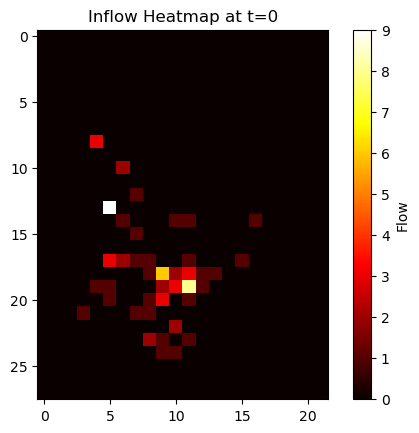

In [8]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()
heatmap = ax.imshow(data[0, 0], cmap='hot', interpolation='nearest')
cbar = plt.colorbar(heatmap, ax=ax, label='Flow')
title = ax.set_title('Inflow Heatmap at t=0')

def update(frame):
    heatmap.set_data(data[frame, 0])
    title.set_text(f'Inflow Heatmap at t={frame}')
    return heatmap, title

ani = animation.FuncAnimation(fig, update, frames=range(0, data.shape[0]), interval=100, blit=False)

plt.show()


In [9]:
ani.save('inflow_animation.gif', writer='pillow')
